# 4. Ensembles de Arboles de Decision

## 4.06 GBDT LightGBM

La técnica de Gradient Boosting fue creada por Jerome H. Friedman en 1999 - 2001
<br>Se implementaron librerías ineficientes
<br>En 2016 se crea XGBoost, en 2017 LightGBM




Paper original de  Gradient Boosting


Friedman JH. Greedy function approximation: A gradient
boosting machine. Ann Stat. 2001;29(5):1189–232. https://
doi.org/10.1214/aos/1013203451.
<br>
https://projecteuclid.org/journals/annals-of-statistics/volume-29/issue-5/Greedy-function-approximation-A-gradient-boosting-machine/10.1214/aos/1013203451.pdf

Paper XGBoost

Chen, T.; Guestrin, C. Xgboost: A scalable tree boosting system. In Proceedings of the 22nd ACM Sigkdd International Conference on Knowledge Discovery and Data Mining, San Francisco, CA, USA, 13–17 August 2016; pp. 785–794.

https://dl.acm.org/doi/pdf/10.1145/2939672.2939785

Paper  LightGBM

Ke G., Meng Q., Finley T., Wang T., Chen W., Ma W., et al.
Lightgbm: A highly efficient gradient boosting decision tree
Advances in Neural Information Processing Systems, 30 (2017)

https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf

Videos "simplificados" :
*  https://www.youtube.com/watch?v=3CC4N4z3GJc
*  https://www.youtube.com/watch?v=2xudPOBz-vs
*  https://www.youtube.com/watch?v=jxuNLH5dXCs
*  https://www.youtube.com/watch?v=StWY5QWMXCw

Artículos ligeros:
*  https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/
*   https://www.machinelearningplus.com/machine-learning/an-introduction-to-gradient-boosting-decision-trees/
*   https://medium.com/@ruchi.awasthi63/gradient-boosted-decision-tree-clearly-explained-bd1d8c7d9923
*   https://medium.com/data-science/a-visual-understanding-of-decision-trees-and-gradient-boosting-c6bc53f982ce
*   https://medium.com/analytics-vidhya/introduction-to-the-gradient-boosting-algorithm-c25c653f826b
*   https://medium.com/@datasciencewizards/understanding-the-gradient-boosting-algorithm-9fe698a352ad

El Gradient Boosting of Decision Trees es un ensemble de árboles de decisión, para un nuevo registro la predicción se hace sumando el score que cada arbol asigna a ese registro.

En GBDT la construccion de los árboles es secuencial, ya que el arbol n-simo se genera para predecir el error del modelo conformado por los n-1 arboles previos, aunque sea un arbol de clasificación lo que se predice es un numero real mediante un arbol de regresión.

<br>Qué tipo de perturbaciones se realiza LightGBM

*   Se perturba el dataset, seleccionando para cada arbol un subconjunto de las columnas.
*   El algortimo de arbol de decisión no presenta perturbaciones

Cada arbolito de LightGBM se entrena sobre un dataset perturbado, que en principio posee :
* todos los registros del dataset original
* solo un porcentaje *feature_fraction* de las columnas originales del dataset

#### 4.06.1  Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Type -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [1]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

Mounted at /content/.drive


<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   Bajar el  **competencia_01_crudo**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab

In [2]:
%%shell

mkdir -p "/content/.drive/My Drive/dmeyf"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/dmeyf" /content/buckets/b1


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/competencia_01_crudo.csv"
archivo_destino="/content/datasets/competencia_01_crudo.csv"
archivo_destino_bucket="/content/buckets/b1/datasets/competencia_01_crudo.csv"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


## Generacion de la clase_ternaria

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

In [1]:
require( "data.table" )

# leo el dataset
dataset <- fread("/content/datasets/competencia_01_crudo.csv" )

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
    "pos" = .I,
    numero_de_cliente,
    periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 ) ]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
    shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente ]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
    ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
    clase_ternaria := "BAJA+1" ]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
    & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
    clase_ternaria := "BAJA+2" ]


# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

fwrite( dataset,
    file =  "/content/datasets/competencia_01.csv.gz",
    sep = ","
)

Loading required package: data.table



In [2]:
setorder( dataset, foto_mes, clase_ternaria, numero_de_cliente)
dataset[, .N, list(foto_mes, clase_ternaria)]

foto_mes,clase_ternaria,N
<int>,<chr>,<int>
202101,BAJA+1,622
202101,BAJA+2,825
202101,CONTINUA,160080
202102,BAJA+1,831
202102,BAJA+2,1032
202102,CONTINUA,160292
202103,BAJA+1,1039
202103,BAJA+2,951
202103,CONTINUA,161119


### 4.07  LightGBM, una corrida

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

limpio el ambiente de R

In [62]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "Sun Sep 07 04:24:52 AM 2025"

In [63]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2499305,133.5,4432287,236.8,4432287,236.8
Vcells,29709384,226.7,123100739,939.2,240419962,1834.3


In [64]:
# cargo las librerias que necesito
require("data.table")
require("rpart")

if(!require("R.utils")) install.packages("R.utils")
require("R.utils")

if( !require("rlist") ) install.packages("rlist")
require("rlist")

if( !require("lightgbm") ) install.packages("lightgbm")
require("lightgbm")

Aqui debe cargar SU semilla primigenia

In [66]:
PARAM <- list()
PARAM$experimento <- 4070
PARAM$semilla_primigenia <- 111119

# training y future
PARAM$train <- c(202102)
PARAM$future <- c(202104)

# estos hiperparametros de LightGBM surgieron de una Bayesian Optimization
PARAM$lgb$num_iterations <- 600  # cantidad de arbolitos
PARAM$lgb$learning_rate <- 0.01002598
PARAM$lgb$feature_fraction <- 0.3260158
PARAM$lgb$min_data_in_leaf <- 3009
PARAM$lgb$num_leaves <- 495
PARAM$lgb$max_bin <- 31

PARAM$semilla_kaggle <- 314159

In [67]:
# particionar agrega una columna llamada fold a un dataset
#   que consiste en una particion estratificada segun agrupa
# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(data, division, agrupa= "", campo= "fold", start= 1, seed= NA) {
  if (!is.na(seed)) set.seed(seed, "L'Ecuyer-CMRG")

  bloque <- unlist(mapply(
    function(x, y) {rep(y, x)},division, seq(from= start, length.out= length(division))))

  data[, (campo) := sample(rep(bloque,ceiling(.N / length(bloque))))[1:.N],by= agrupa]
}

In [68]:
# iniciliazo el dataset de realidad, para medir ganancia
realidad_inicializar <- function( pfuture, pparam) {

  # datos para verificar la ganancia
  drealidad <- pfuture[, list(numero_de_cliente, foto_mes, clase_ternaria)]

  particionar(drealidad,
    division= c(3, 7),
    agrupa= "clase_ternaria",
    seed= PARAM$semilla_kaggle
  )

  return( drealidad )
}

In [69]:
# evaluo ganancia en los datos de la realidad

realidad_evaluar <- function( prealidad, pprediccion) {

  prealidad[ pprediccion,
    on= c("numero_de_cliente", "foto_mes"),
    predicted:= i.Predicted
  ]

  tbl <- prealidad[, list("qty"=.N), list(fold, predicted, clase_ternaria)]

  res <- list()
  res$public  <- tbl[fold==1 & predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]/0.3
  res$private <- tbl[fold==2 & predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]/0.7
  res$total <- tbl[predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]

  prealidad[, predicted:=NULL]
  return( res )
}

In [70]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento_folder <- paste0("KA_B", PARAM$experimento)
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

In [71]:
# lectura del dataset
dataset <- fread("/content/datasets/competencia_01.csv.gz", stringsAsFactors= TRUE)

In [72]:
# paso la clase a binaria

dataset[, clase01 := ifelse(clase_ternaria %in% c("BAJA+2"), 1L, 0L)]

In [73]:
# los campos que se van a utilizar

campos_buenos <- copy(setdiff(colnames(dataset), c("clase_ternaria", "clase01")))

In [74]:
# establezco donde entreno

dataset[, train := 0L]
dataset[foto_mes %in% PARAM$train, train := 1L]

In [75]:
# dejo los datos en el formato que necesita LightGBM

dtrain <- lgb.Dataset(
  data= data.matrix(dataset[train == 1L, campos_buenos, with= FALSE]),
  label= dataset[train == 1L, clase01]
)

In [76]:
# genero el modelo
# estos hiperparametros  salieron de una laaarga Optmizacion Bayesiana

set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG") # Establezco la semilla aleatoria

modelo <- lgb.train(
  data= dtrain,
  param= list(
  objective= "binary",
  max_bin= PARAM$lgb$max_bin,
  learning_rate= PARAM$lgb$learning_rate,
  num_iterations= PARAM$lgb$num_iterations,
  num_leaves= PARAM$lgb$num_leaves,
  min_data_in_leaf= PARAM$lgb$min_data_in_leaf,
  feature_fraction= PARAM$lgb$feature_fraction,
  seed= PARAM$semilla_primigenia
  )
)


[LightGBM] [Info] Number of positive: 1032, number of negative: 161123
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 162155, number of used features: 123
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006364 -> initscore=-5.050669
[LightGBM] [Info] Start training from score -5.050669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [77]:
# ahora imprimo la importancia de variables
tb_importancia <- as.data.table(lgb.importance(modelo))
archivo_importancia <- "impo_2.txt"

fwrite(tb_importancia,
  file= archivo_importancia,
  sep= "\t"
)


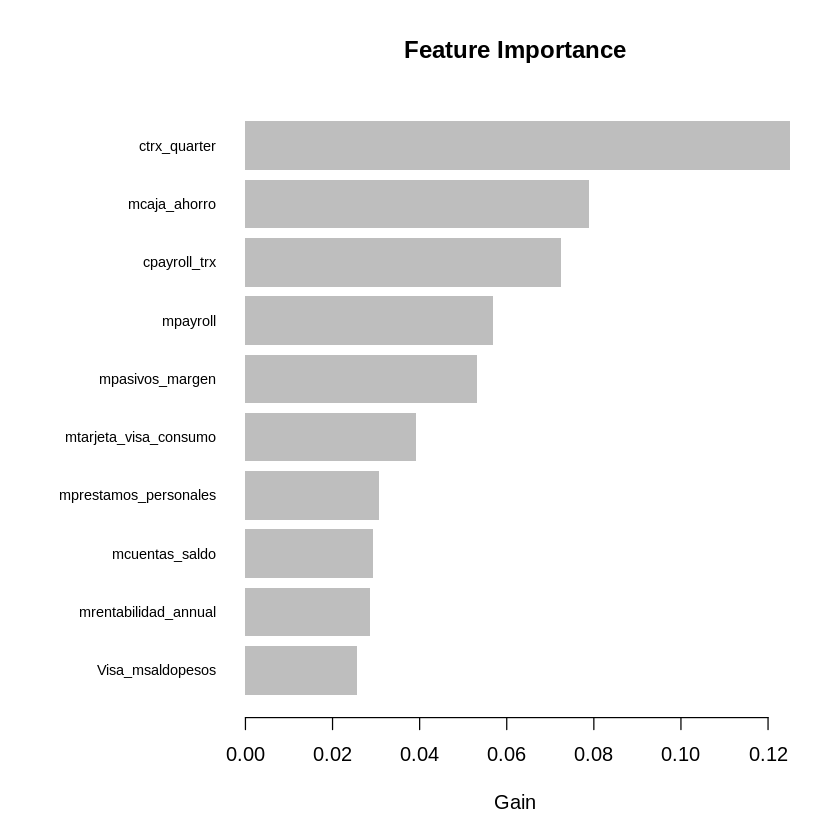

In [78]:
lgb.plot.importance(tb_importancia, measure = "Gain", top_n = 10)

#ctrx_quarter: movimientos en el mes
#cpayroll_trx: Q acreditaciones de haberes en rr de dep (solo empresas relacionadas con el banco - creo que no dice nada)
#mpayroll: monto total acreditado en el mes

In [79]:
# grabo a disco el modelo en un formato para seres humanos ... ponele ...

lgb.save(modelo, "modelo_2.txt" )

In [80]:
# mes donde voy a aplicar el modelo
dfuture <- dataset[foto_mes %in% PARAM$future]
setorder(dfuture, numero_de_cliente, foto_mes)

# inicilizo el dataset  drealidad
drealidad <- realidad_inicializar( dfuture, PARAM)

In [81]:
# aplico el modelo a los datos nuevos
prediccion <- predict(
  modelo,
  data.matrix(dfuture[, campos_buenos, with= FALSE])
)

In [82]:
# tabla de prediccion

tb_prediccion <- dfuture[, list(numero_de_cliente, foto_mes)]
tb_prediccion[, prob := prediccion ]

# grabo las probabilidad del modelo
fwrite(tb_prediccion,
  file= "prediccion_2.txt",
  sep= "\t"
)

In [83]:
# ordeno por probabilidad descendente

setorder(tb_prediccion, -prob)

In [84]:
# genero la prediccion

tb_prediccion[, Predicted := 0L]
tb_prediccion[prob>(1/40), Predicted := 1L]

archivo_kaggle <- paste0("KA_B", PARAM$experimento, ".csv")

# grabo el archivo
fwrite(tb_prediccion[, list(numero_de_cliente, Predicted)],
  file= archivo_kaggle,
  sep= ","
)

In [85]:
# calculo la ganancia en los datos del futuro
res <- realidad_evaluar( drealidad, tb_prediccion)

cat( "TOTAL=", res$total,
  " Public=", res$public,
  " Private=", res$private,
  "\n",
  sep= ""
)

TOTAL=333220000 Public=291466667 Private=351114286


In [86]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "Sun Sep 07 04:34:21 AM 2025"



---



### 4.08  LightGBM  optimizacion de hiperparámetros

La optimizacion de los hiperparámetros de LightGBM mediante el método de optimizacion bayesiana será su *caballito de batalla* durante la asignatura !

limpio el ambiente de R

In [41]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "Sat Sep 06 10:43:50 PM 2025"

In [42]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1928324,103.0,2977450,159.1,2977450,159.1
Vcells,3725851,28.5,192344903,1467.5,240419962,1834.3


In [43]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

if(!require("R.utils")) install.packages("R.utils")
require("R.utils")

if( !require("primes") ) install.packages("primes")
require("primes")

if( !require("rlist") ) install.packages("rlist")
require("rlist")

if( !require("lightgbm") ) install.packages("lightgbm")
require("lightgbm")

if( !require("DiceKriging") ) install.packages("DiceKriging")
require("DiceKriging")

if( !require("mlrMBO") ) install.packages("mlrMBO")
require("mlrMBO")


Loading required package: parallel

Loading required package: primes

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘primes’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: primes

Loading required package: DiceKriging

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘DiceKriging’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: DiceKriging

Loading required package: mlrMBO

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘mlrMBO’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fastmatch’, ‘RcppArmadillo’, ‘mlr’, ‘ParamHelpers’, ‘smoof’, ‘BBmisc’, ‘c

Aqui debe cargar SU semilla primigenia

In [46]:
PARAM <- list()
PARAM$experimento <- 4080
PARAM$semilla_primigenia <- 111119

# training y future
PARAM$train <- c(202102)

# un undersampling de 0.1  toma solo el 10% de los CONTINUA
# undersampling de 1.0  implica tomar TODOS los datos
PARAM$trainingstrategy$undersampling <- 1.0

PARAM$hyperparametertuning$iteraciones <- 40 # iteracines bayesianas    --------- toma combinaciones de HP

PARAM$hyperparametertuning$xval_folds <- 5

# parametros fijos del LightGBM
PARAM$lgbm$param_fijos <- list(
  objective= "binary",
  metric= "auc",
  first_metric_only= TRUE,
  boost_from_average= TRUE,
  feature_pre_filter= FALSE,
  verbosity= -100,
  force_row_wise= TRUE, # para evitar warning
  seed= PARAM$semilla_primigenia,
  max_bin= 31,
  num_iterations= 2048,  # valor grande, lo limita early_stopping_rounds  ------ cantidad de árboles
  early_stopping_rounds= 200    # ---------- para si hace 200 árboles que no aportan
)

# Aqui se cargan los bordes de los hiperparametros
PARAM$hypeparametertuning$hs <- makeParamSet(
  makeNumericParam("learning_rate", lower= 0.01, upper= 0.5),
  makeNumericParam("feature_fraction", lower= 0.1, upper= 1.0),
  makeIntegerParam("num_leaves", lower= 8L, upper= 2048L),
  makeIntegerParam("min_data_in_leaf", lower= 1L, upper= 8000L)
)


In [44]:
#Diccionario CHATGPT

#Learning rate: Qué tanto contribuye cada árbol a la predicción final. Menor valor = más estable pero requiere más árboles.
#Usualmente se combina un learning_rate bajo (0.01–0.05) con num_iterations alto (500–5000) para mejorar la generalización.

#Ver goss: modo de sampleo para tomar mejores gradientes:
#top_rate	Proporción de datos con gradientes más grandes que siempre se mantienen.	0.1 – 0.3
#other_rate	Proporción de datos con gradientes más pequeños que se toman aleatoriamente.	0.05 – 0.2
#GOSS es un boosting eficiente para datasets masivos, logrando casi la misma precisión que GBDT pero con mucho menos costo computacional.
#Se quedan todas las observaciones con gradientes grandes
#Estas son las predicciones donde el modelo está cometiendo errores grandes.


#learning_rate ajusta la contribución de cada árbol:
#learning_rate = 0.1 → cada árbol aporta solo el 10% de lo que predice.
#learning_rate = 0.5 → cada árbol aporta la mitad de su predicción.
#Esto significa que learning_rate más pequeño → entrenamiento más lento pero más estable y menos propenso a overfitting.

In [47]:
# En el argumento x llegan los parametros de la bayesiana
#  devuelve la AUC de cross validation del modelo entrenado

EstimarGanancia_AUC_lightgbm <- function(x) {

  message(format(Sys.time(), "%a %b %d %X %Y"))

  # uno la lista de hiperparametros : fijos + variables
  param_completo <- c(PARAM$lgbm$param_fijos, x)

  # entreno LightGBM
  modelocv <- lgb.cv(
    data= dtrain,
    nfold= PARAM$hyperparametertuning$xval_folds,
    stratified= TRUE,
    param= param_completo,
    verbose= -100
  )

  # obtengo la ganancia
  AUC <- modelocv$best_score

  # esta es la forma de devolver un parametro extra
  attr(AUC, "extras") <- list("num_iterations"= modelocv$best_iter)

  # hago espacio en la memoria
  rm(modelocv)
  gc(full= TRUE, verbose= FALSE)

  message( "AUC: ", AUC)
  return(AUC)
}

aqui se inicia el programa

In [48]:
# carpeta de trabajo

setwd("/content/buckets/b1/exp")
experimento_folder <- paste0("HT", PARAM$experimento)
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

In [49]:
# en este archivo quedan la evolucion binaria de la BO
kbayesiana <- "bayesiana.RDATA"

In [50]:
# lectura del dataset
dataset <- fread("/content/datasets/competencia_01.csv.gz", stringsAsFactors= TRUE)

In [51]:
dataset <- dataset[foto_mes %in%  PARAM$train]

In [52]:
# paso la clase a binaria que tome valores {0,1}  enteros
dataset[, clase01 := ifelse(clase_ternaria == "BAJA+2", 1L, 0L) ]

In [53]:
# los campos que se van a utilizar ---------- definir qué campos quiero !!!!!!!

campos_buenos <- copy( setdiff(
  colnames(dataset),
  c("clase_ternaria", "clase01", "azar", "training")
))


#colnames(dataset) → toma todas las columnas del dataset.
#setdiff(..., c("clase_ternaria", "clase01", "azar", "training")) → quita estas 4 columnas.


In [54]:
# defino los datos que forma parte del training
# aqui se hace el undersampling de los CONTINUA
# notar que para esto utilizo la SEGUNDA semilla

set.seed(PARAM$semilla_primigenia, kind= "L'Ecuyer-CMRG")
dataset[, azar := runif(nrow(dataset))]
dataset[, training := 0L]

dataset[
  foto_mes %in% PARAM$train &
    (azar <= PARAM$trainingstrategy$undersampling | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
  training := 1L
]

In [55]:
# dejo los datos en el formato que necesita LightGBM

dtrain <- lgb.Dataset(
  data= data.matrix(dataset[training == 1L, campos_buenos, with= FALSE]),
  label= dataset[training == 1L, clase01],
  free_raw_data= FALSE
)

nrow(dtrain)
ncol(dtrain)

[1] 162155

[1] 154

In [56]:
# Aqui comienza la configuracion de la Bayesian Optimization

funcion_optimizar <- EstimarGanancia_AUC_lightgbm # la funcion que voy a maximizar

configureMlr(show.learner.output= FALSE)

# configuro la busqueda bayesiana,  los hiperparametros que se van a optimizar
# por favor, no desesperarse por lo complejo

obj.fun <- makeSingleObjectiveFunction(
  fn= funcion_optimizar, # la funcion que voy a maximizar
  minimize= FALSE, # estoy Maximizando la ganancia
  noisy= TRUE,
  par.set= PARAM$hypeparametertuning$hs, # definido al comienzo del programa
  has.simple.signature= FALSE # paso los parametros en una lista
)

# cada 600 segundos guardo el resultado intermedio
ctrl <- makeMBOControl(
  save.on.disk.at.time= 600, # se graba cada 600 segundos
  save.file.path= kbayesiana
) # se graba cada 600 segundos

# indico la cantidad de iteraciones que va a tener la Bayesian Optimization
ctrl <- setMBOControlTermination(
  ctrl,
  iters= PARAM$hyperparametertuning$iteraciones
) # cantidad de iteraciones

# defino el método estandar para la creacion de los puntos iniciales,
# los "No Inteligentes"
ctrl <- setMBOControlInfill(ctrl, crit= makeMBOInfillCritEI())

# establezco la funcion que busca el maximo
surr.km <- makeLearner(
  "regr.km",
  predict.type= "se",
  covtype= "matern3_2",
  control= list(trace= TRUE)
)


In [60]:
bayesiana_salida

Recommended parameters:
learning_rate=0.01; feature_fraction=0.326; num_leaves=495; min_data_in_leaf=3009
Objective: y = 0.910

Optimization path
16 + 40 entries in total, displaying last 10 (or less):
   learning_rate feature_fraction num_leaves min_data_in_leaf         y dob eol
47    0.07202615        0.4696431       2045             7440 0.9045831  31  NA
48    0.15923120        0.7704516       2048             5672 0.9033531  32  NA
49    0.14776849        0.9999721        860             5605 0.9031544  33  NA
50    0.01002598        0.3260158        495             3009 0.9101331  34  NA
51    0.27841742        0.9612380          8             7998 0.9034666  35  NA
52    0.01044873        0.9997456       2038             1011 0.9044270  36  NA
53    0.06245883        0.9986394        244             2918 0.9065355  37  NA
54    0.07225672        0.7677021         25                5 0.8944578  38  NA
55    0.01018406        0.1105011       1852             1835 0.9038835  39  N

In [57]:
# inicio la optimizacion bayesiana, retomando si ya existe

if (!file.exists(kbayesiana)) {
  bayesiana_salida <- mbo(obj.fun, learner= surr.km, control= ctrl)
} else {
  bayesiana_salida <- mboContinue(kbayesiana) # retomo en caso que ya exista
}

Computing y column(s) for design. Not provided.

Sat Sep 06 11:59:04 PM 2025

AUC: 0.900056401612024

Sun Sep 07 12:01:20 AM 2025

AUC: 0.900459311261603

Sun Sep 07 12:02:54 AM 2025

AUC: 0.904479623928106

Sun Sep 07 12:05:03 AM 2025

AUC: 0.905978784070022

Sun Sep 07 12:07:31 AM 2025

AUC: 0.88450675761376

Sun Sep 07 12:09:28 AM 2025

AUC: 0.899526682419217

Sun Sep 07 12:10:59 AM 2025

AUC: 0.90016792519094

Sun Sep 07 12:12:50 AM 2025

AUC: 0.893688669792684

Sun Sep 07 12:14:23 AM 2025

AUC: 0.898428115722862

Sun Sep 07 12:15:47 AM 2025

AUC: 0.903595392642308

Sun Sep 07 12:17:06 AM 2025

AUC: 0.907912435525299

Sun Sep 07 12:19:30 AM 2025

AUC: 0.900364453036951

Sun Sep 07 12:21:09 AM 2025

AUC: 0.869093865946025

Sun Sep 07 12:23:06 AM 2025

AUC: 0.905859299813412

Sun Sep 07 12:25:32 AM 2025

AUC: 0.894921252320895

Sun Sep 07 12:27:09 AM 2025

AUC: 0.907158450418958

[mbo] 0: learning_rate=0.231; feature_fraction=0.479; num_leaves=1621; min_data_in_leaf=1303 : y = 0.9 : 

In [58]:
# almaceno los resultados de la Bayesian Optimization
# y capturo los mejores hiperparametros encontrados

tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)

tb_bayesiana[, iter:= .I]
# ordeno en forma descendente por AUC = y
setorder(tb_bayesiana, -y, -num_iterations)

# grabo para eventualmente poder utilizarlos en OTRA corrida
fwrite( tb_bayesiana,
  file= "BO_log.txt",
  sep= "\t"
)

# los mejores hiperparámetros son los que quedaron en el registro 1 de la tabla
PARAM$out$lgbm$mejores_hiperparametros <- tb_bayesiana[
  1, # el primero es el de mejor AUC
  list(learning_rate, feature_fraction, num_leaves, min_data_in_leaf, num_iterations)
]

print(PARAM$out$lgbm$mejores_hiperparametros)

   learning_rate feature_fraction num_leaves min_data_in_leaf num_iterations
           <num>            <num>      <int>            <int>          <int>
1:    0.01002598        0.3260158        495             3009            600


In [61]:
tb_bayesiana

learning_rate,feature_fraction,num_leaves,min_data_in_leaf,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean,num_iterations,iter
<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.01002598,0.3260158,495,3009,0.9101331,34,NA,NA,367.486,-0.0004907463,NA,0.041,infill_ei,0.417,0.0005466788,0.9100978,600,50
0.01004850,0.3399774,424,3637,0.9096762,29,NA,NA,393.504,-0.0005408575,NA,0.055,infill_ei,0.405,0.0017768177,0.9091886,662,45
0.01017813,0.4096358,1934,2447,0.9095545,15,NA,NA,367.849,-0.0006851308,NA,0.022,infill_ei,0.371,0.0013563509,0.9097785,501,31
0.01136271,0.2933043,2036,1903,0.9095113,14,NA,NA,302.697,-0.0027563411,NA,0.045,infill_ei,0.356,0.0040360644,0.9106248,437,30
0.01006376,0.2387625,486,2387,0.9092872,21,NA,NA,355.963,-0.0014145542,NA,0.023,infill_ei,0.384,0.0020312794,0.9105660,643,37
0.01009366,0.8074528,290,2598,0.9087233,26,NA,NA,312.579,-0.0012325561,NA,0.030,infill_ei,0.675,0.0025645455,0.9099492,530,42
0.01001760,0.2559147,1291,3566,0.9086940,10,NA,NA,407.296,-0.0025229749,NA,0.032,infill_ei,0.371,0.0031572101,0.9099380,777,26
0.04324767,0.2606199,1992,2477,0.9082009,24,NA,NA,172.117,-0.0007588850,NA,0.032,infill_ei,0.546,0.0022603877,0.9092527,182,40
0.08510318,0.3326360,1994,4760,0.9080750,13,NA,NA,123.993,-0.0023409636,NA,0.023,infill_ei,0.386,0.0039017818,0.9100709,79,29


In [59]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "Sun Sep 07 03:34:23 AM 2025"

Una vez que se impriman los mejores hiperparametros proceder:


1.   Copielos en el punto 4.07  en la celda donde se define PARAM
2.   Ejecute el punto 4.07 con estos hiperparámetros optimos
2.   Reporte el resultado en la hoja  **C4-LGBM Bayesiana**  de la  planilla colaborativa




---

